In [3]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

In [44]:
# observations
types = ['Low Freq', 'High Freq', 'Two-Way']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

In [53]:

for i,t in enumerate(types):
    print(f'{t} Prevalence: {(alphas[i]+c[i])/(c.sum()+alphas.sum())}')

Low Freq Prevalence: 0.4444444444444444
High Freq Prevalence: 0.3333333333333333
Two-Way Prevalence: 0.2222222222222222


Now, let's try a few different hyperparameter values (our previous beliefs) and see how that affects the expected value.

In [47]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = types)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,Low Freq,High Freq,Two-Way,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


### PyMC3 and MCMC
With enough samples, the estimate will converge on the true posterior. Along with single point estimates (such as the mean of sampled values), MCMC also gives us built in uncertainty because we get thousands of possible values from the posterior.


In [48]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)    

## Sampling from the Model

The cell below samples 1000 draws from the posterior in 2 chains. We use 500 samples for tuning which are discarded. This means that for each random variable  in the model - the `parameters` - we will have 2000 values drawn from the posterior distribution. 

In [49]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.


## Inspecting Results



In [50]:
summary = pm.summary(trace)
summary.index = types
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Low Freq,0.444,0.152,0.164,0.721,0.004,0.003,1529.0,1398.0,1533.0,1121.0,1.0
High Freq,0.337,0.147,0.074,0.604,0.004,0.003,1639.0,1580.0,1644.0,1457.0,1.0
Two-Way,0.218,0.128,0.019,0.454,0.003,0.002,1390.0,1390.0,1387.0,1478.0,1.0


Instead of just getting one number, we get a range of uncertainty as indicated by the large standard deviation and 95% highest probability interval.

In [51]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = types)
trace_df.head()

,Low Freq,High Freq,Two-Way
0,0.907417,0.059766,0.032817
1,0.056577,0.793433,0.149990
2,0.147775,0.716902,0.135324
3,0.525277,0.146243,0.328480
4,0.541152,0.195971,0.262877


For a single point estimate, we can use the mean of the samples.

In [54]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
print(dict(zip(types, pvals)))


{'Low Freq': 0.4444003826428859, 'High Freq': 0.33748621518497673, 'Two-Way': 0.21811340217213807}


These numbers align nearly exactly with the expected values! However, we also get a range of uncertainty.

In [35]:
summary.iloc[:, 3:5]

,hdi_97%,mcse_mean
Low Freq,0.765,0.004
High Freq,0.589,0.003
Two-Way,0.478,0.003





## Posterior Plot

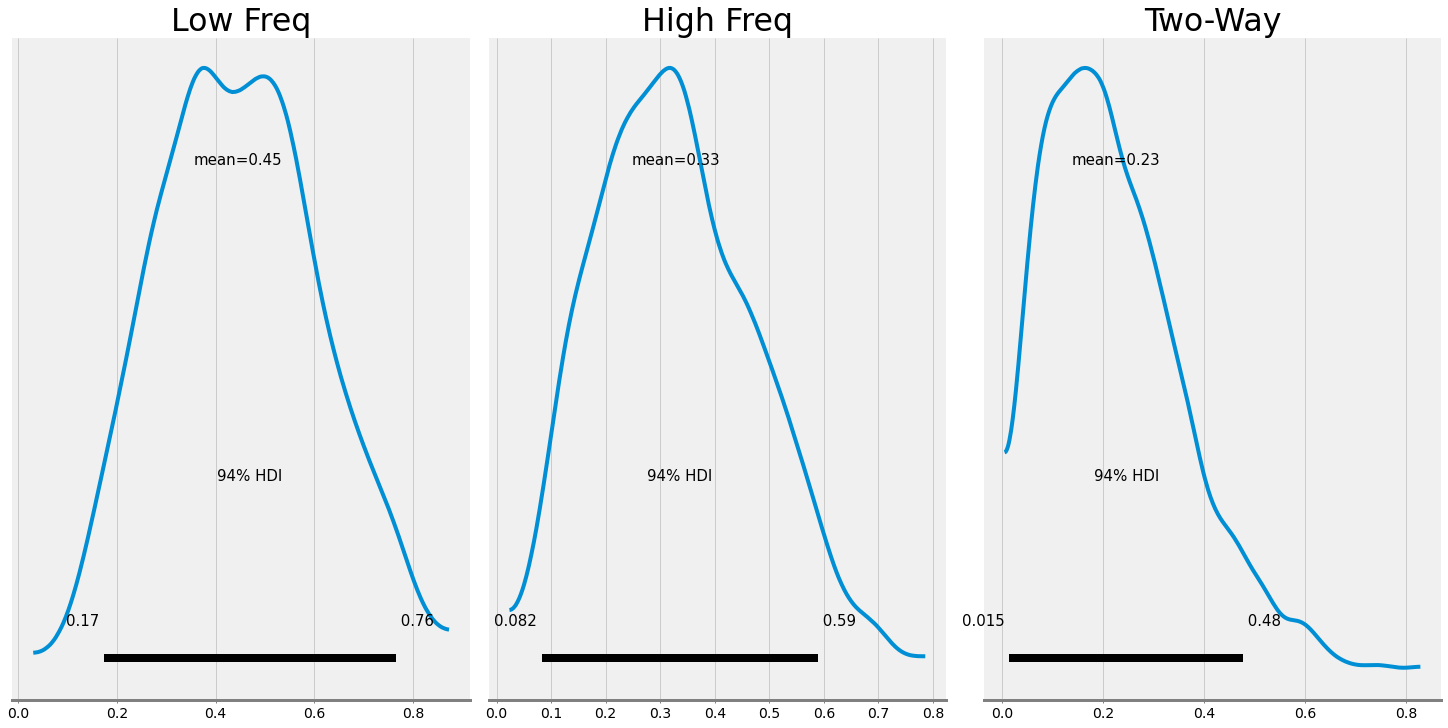

In [42]:
ax = pm.plot_posterior(trace, var_names = ['parameters'], 
                       figsize = (20, 10));

plt.rcParams['font.size'] = 22
for i, a in enumerate(types):
    ax[i].set_title(a);

What we see hear is a histogram of the sampled values. 

The 95% HPD is the same idea as a 95% confidence interval in frequentist statistics. In Bayesian stats, this is called the Highest Posterior Density.

## Traceplot

The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. 

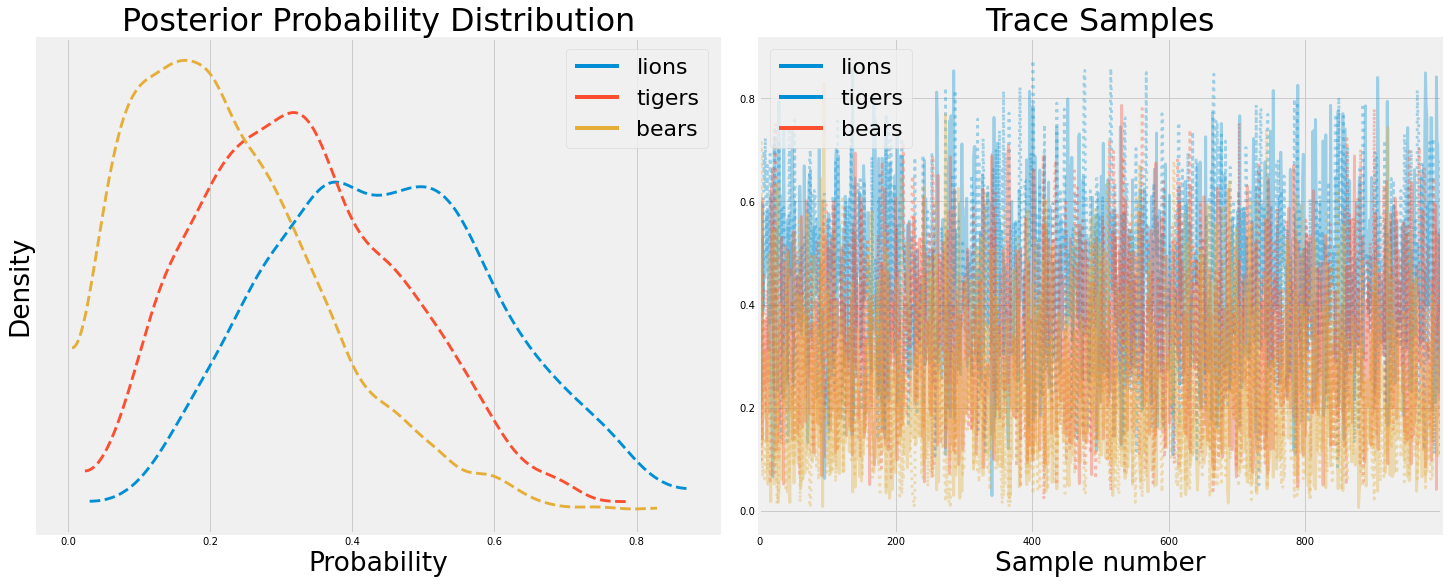

In [43]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, var_names = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
add_legend(ax[0][0])
add_legend(ax[0][1])

## Anomaly Detection


We can now detect anomalies based on the possible posterior space of the (joint) distribution extracted from the data.  For example, if there is a 95% chance that an observation should not occur under the posterior distribution, that observation could be flagged as "anomalous".  Alternatively, there exist models specifically designed to identify outliers from distributions:

## Isolation Forests 

In [63]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

from sklearn.ensemble import IsolationForest



In [64]:
# Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

In [65]:
# training the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)

# predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

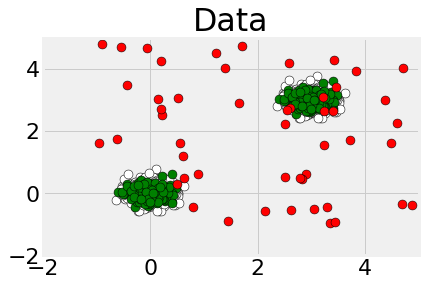

In [66]:
plt.title("Data")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
#plt.legend([p1, p2, p3],
#           ["training observations",
#            "new regular obs.", "new abnormal obs."],
#           loc="lower right")

# saving the figure
plt.savefig('generated_data.png', dpi=300)

plt.show()

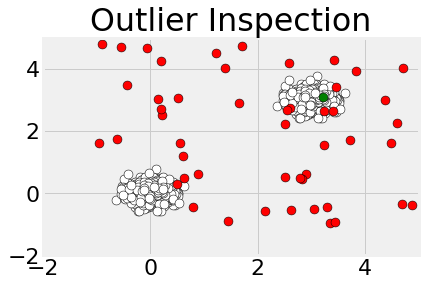

In [62]:

# Inspecting the outliers ----

# adding the predicted label
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Outlier Inspection")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
#plt.legend([p1, p2, p3],
 #          ["training observations",
  #          "detected outliers", 
   #         "detected regular obs."],
    #       loc="lower right")

# saving the figure
plt.savefig('outlier_inspection.png', dpi=300)

plt.show()